<a href="https://colab.research.google.com/github/CHGROSJEAN/2024_MLEES/blob/main/Projet/Projet_Charlotte_Grosjean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. SIMPLE GMM BASELINE FOR 2 STATIONS

Frist step, simple GMM for 2 stations : Grand-Vennes and Riand-Pré.

# 1.1 Import libraries and data


In [19]:
# Import
import geopandas as gpd
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
from shapely.geometry import Point
from sklearn.metrics import silhouette_score



Download data sets

In [20]:
# Reading the Excel files
grandvennes = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/GrandVennes.xlsx")
riandpre = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/RiandPre.xlsx")

# Displaying the first few rows of each dataset
print("Data from file1:")
print(grandvennes.head())

print("\nData from file2:")
print(riandpre.head())

Data from file1:
   Index             DateTime  Precipitation
0      1  07.01.2023 08:27:54              0
1      2  07.01.2023 08:30:54              0
2      3  07.01.2023 08:33:54              0
3      4  07.01.2023 08:36:54              0
4      5  07.01.2023 08:39:54              0

Data from file2:
   Index             DateTime  Precipitation
0      1  09.11.2022 00:03:39              0
1      2  09.11.2022 00:06:39              0
2      3  09.11.2022 00:09:39              0
3      4  09.11.2022 00:12:39              0
4      5  09.11.2022 00:15:39              0


# 1.2 Preprocessing and visualization


Pre-processing the data to ensure the data is clean following the following steps:
- Setting DateTime as the index
- Selecting the period (data for both station)
- Converting drops in mm
- Remove the seconds units to have minute precision
- Aligning both datasets to the period (Both dataset have 3 minutes interval)
- If some time points are still missing from one station, drop them from the analysis
- Merge datasets in 1 dataset for GMM

In [21]:
# Ensuring the 'DateTime' column is of datetime type for both datasets
grandvennes['DateTime'] = pd.to_datetime(grandvennes['DateTime'], dayfirst=True)
riandpre['DateTime'] = pd.to_datetime(riandpre['DateTime'], dayfirst=True)

# Setting the DateTime column as the index for easier time-based operations
grandvennes.set_index('DateTime', inplace=True)
riandpre.set_index('DateTime', inplace=True)

<ipython-input-22-dd174b548b5a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grandvennes_filtered['Precipitation_mm'] = grandvennes_filtered['Precipitation'] * 0.01
<ipython-input-22-dd174b548b5a>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  riandpre_filtered['Precipitation_mm'] = riandpre_filtered['Precipitation'] * 0.01


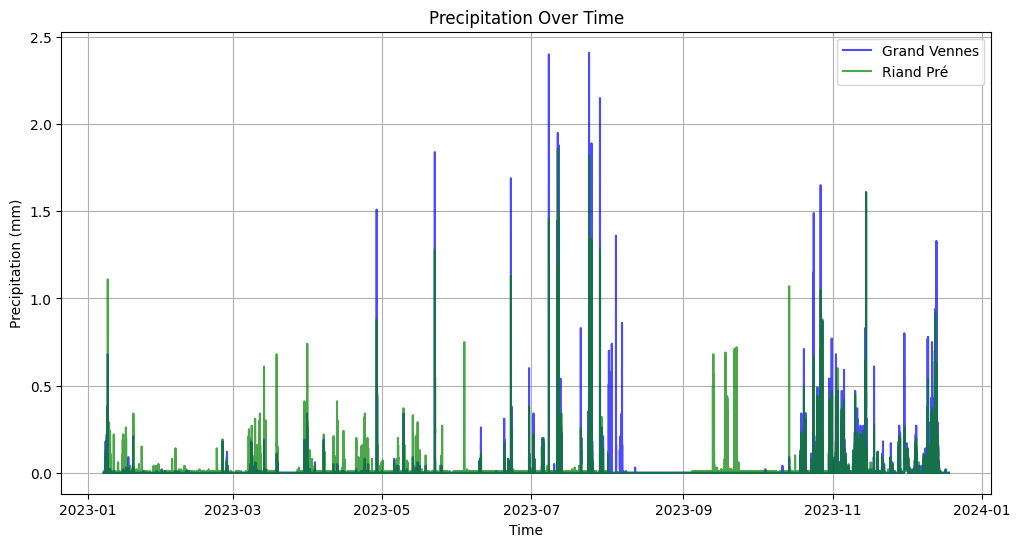

In [22]:
#Finding the common time period between the two datasets
start_time = max(grandvennes.index.min(), riandpre.index.min())
end_time = min(grandvennes.index.max(), riandpre.index.max())

# Filtering both datasets to the common time period
grandvennes_filtered = grandvennes.loc[start_time:end_time]
riandpre_filtered = riandpre.loc[start_time:end_time]

# Converting precipitation from drops to mm ( 1 drop = 0.01 mm)
grandvennes_filtered['Precipitation_mm'] = grandvennes_filtered['Precipitation'] * 0.01
riandpre_filtered['Precipitation_mm'] = riandpre_filtered['Precipitation'] * 0.01

# Plotting the data
plt.figure(figsize=(12, 6))
plt.plot(grandvennes_filtered.index, grandvennes_filtered['Precipitation_mm'], label='Grand Vennes', color='blue', alpha=0.7)
plt.plot(riandpre_filtered.index, riandpre_filtered['Precipitation_mm'], label='Riand Pré', color='green', alpha=0.7)

# Adding labels, title, and legend
plt.xlabel('Time')
plt.ylabel('Precipitation (mm)')
plt.title('Precipitation Over Time')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

Normally, sensors are set to measure every three minutes, starting with the full hour, so that stations take measurements at the same minutes for easier analysis.

So, when we remove the seconds, we round up to the previous minute to keep this matching.

We still have a step to align the two datasets, as some sensors are not set to the same minutes and are therefore out of sync.

In [23]:
# Round down the DateTime to the previous minute (removes seconds, truncating)
grandvennes.index = grandvennes.index.floor('min')  # rounded to the nearest lower minute
riandpre.index = riandpre.index.floor('min')

# Resample both datasets to ensure they have data every 3 minutes (if necessary)
# Resampling to the closest 3-minute interval and filling missing values with NaN
grandvennes_resampled = grandvennes.resample('3min').mean()
riandpre_resampled = riandpre.resample('3min').mean()

# Align both datasets to the common time period (intersection of their timestamps)
start_time = max(grandvennes_resampled.index.min(), riandpre_resampled.index.min())
end_time = min(grandvennes_resampled.index.max(), riandpre_resampled.index.max())

grandvennes_aligned = grandvennes_resampled.loc[start_time:end_time]
riandpre_aligned = riandpre_resampled.loc[start_time:end_time]

# Drop rows with missing values from both datasets
grandvennes_aligned = grandvennes_aligned.dropna()
riandpre_aligned = riandpre_aligned.dropna()

# Now both datasets are aligned and cleaned. Viewing the cleaned and aligned data
print("Aligned and cleaned Grandvennes data:")
print(grandvennes_aligned.head())

print("Aligned and cleaned Riandpre data:")
print(riandpre_aligned.head())


Aligned and cleaned Grandvennes data:
                     Index  Precipitation
DateTime                                 
2023-01-07 08:27:00    1.0            0.0
2023-01-07 08:30:00    2.0            0.0
2023-01-07 08:33:00    3.0            0.0
2023-01-07 08:36:00    4.0            0.0
2023-01-07 08:39:00    5.0            0.0
Aligned and cleaned Riandpre data:
                       Index  Precipitation
DateTime                                   
2023-01-07 08:27:00  28489.0            0.0
2023-01-07 08:30:00  28490.0            0.0
2023-01-07 08:33:00  28491.0            0.0
2023-01-07 08:36:00  28492.0            0.0
2023-01-07 08:39:00  28493.0            0.0


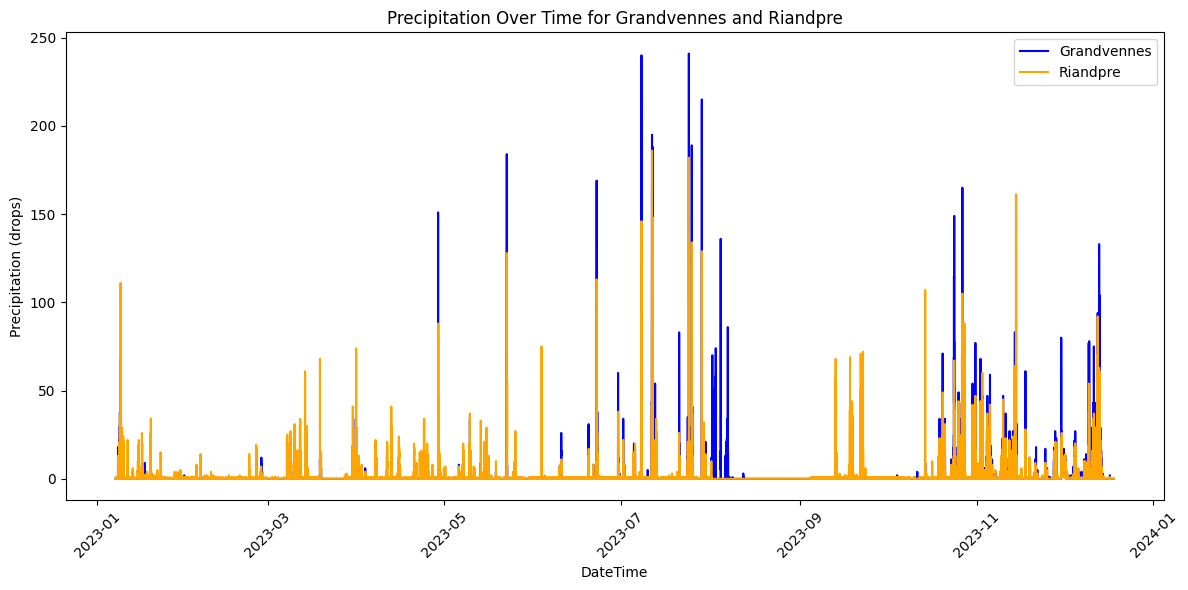

In [24]:
# Plotting the data for both stations
plt.figure(figsize=(12, 6))

# Plot Grand-Vennes data
plt.plot(grandvennes_aligned.index, grandvennes_aligned['Precipitation'], label='Grandvennes', color='blue')

# Plot Riand-Pré data
plt.plot(riandpre_aligned.index, riandpre_aligned['Precipitation'], label='Riandpre', color='orange')

# Add labels and title
plt.xlabel('DateTime')
plt.ylabel('Precipitation (drops)')
plt.title('Precipitation Over Time for Grandvennes and Riandpre')

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Add a legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [25]:
# Merge the datasets on the 'DateTime' index
combined_data = pd.merge(grandvennes_aligned[['Precipitation']],
                         riandpre_aligned[['Precipitation']],
                         left_index=True, right_index=True,
                         suffixes=('_Grandvennes', '_Riandpre'))

# Display the first few rows of the combined data
print("Combined Precipitation Data:")
print(combined_data.head())

Combined Precipitation Data:
                     Precipitation_Grandvennes  Precipitation_Riandpre
DateTime                                                              
2023-01-07 08:27:00                        0.0                     0.0
2023-01-07 08:30:00                        0.0                     0.0
2023-01-07 08:33:00                        0.0                     0.0
2023-01-07 08:36:00                        0.0                     0.0
2023-01-07 08:39:00                        0.0                     0.0


# 1.3 Splitting dataset

Split the dataset following this repartition
- First 70% = Training set
- Next 15% = Validation set  
- Last 15% = Testing set

In [26]:
# Calculate the index for the splits
train_size = int(0.7 * len(combined_data))  # 70% for training
val_size = int(0.15 * len(combined_data))  # 15% for validation
test_size = len(combined_data) - train_size - val_size  # 15% for testing

# Split the data sequentially
train_data = combined_data[:train_size]
val_data = combined_data[train_size:train_size + val_size]
test_data = combined_data[train_size + val_size:]

# Display the sizes of each dataset
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

# Display the first few rows of each dataset
print("\nTraining Data:")
print(train_data.head())

print("\nValidation Data:")
print(val_data.head())

print("\nTest Data:")
print(test_data.head())


Training set size: 92561
Validation set size: 19834
Test set size: 19836

Training Data:
                     Precipitation_Grandvennes  Precipitation_Riandpre
DateTime                                                              
2023-01-07 08:27:00                        0.0                     0.0
2023-01-07 08:30:00                        0.0                     0.0
2023-01-07 08:33:00                        0.0                     0.0
2023-01-07 08:36:00                        0.0                     0.0
2023-01-07 08:39:00                        0.0                     0.0

Validation Data:
                     Precipitation_Grandvennes  Precipitation_Riandpre
DateTime                                                              
2023-09-26 19:18:00                        0.0                     0.0
2023-09-26 19:21:00                        0.0                     0.0
2023-09-26 19:24:00                        0.0                     0.0
2023-09-26 19:27:00                      

In [27]:
# Extract X for each dataset
# For training data
X_train = train_data[['Precipitation_Grandvennes', 'Precipitation_Riandpre']]  # Features (precipitation from both stations)

# For validation data
X_valid = val_data[['Precipitation_Grandvennes', 'Precipitation_Riandpre']]  # Features (precipitation from both stations)

# For test data
X_test = test_data[['Precipitation_Grandvennes', 'Precipitation_Riandpre']]  # Features (precipitation from both stations)

# Display the first few rows of the extracted data
print("X_train:")
print(X_train.head())

print("\nX_valid:")
print(X_valid.head())

print("\nX_test:")
print(X_test.head())

X_train:
                     Precipitation_Grandvennes  Precipitation_Riandpre
DateTime                                                              
2023-01-07 08:27:00                        0.0                     0.0
2023-01-07 08:30:00                        0.0                     0.0
2023-01-07 08:33:00                        0.0                     0.0
2023-01-07 08:36:00                        0.0                     0.0
2023-01-07 08:39:00                        0.0                     0.0

X_valid:
                     Precipitation_Grandvennes  Precipitation_Riandpre
DateTime                                                              
2023-09-26 19:18:00                        0.0                     0.0
2023-09-26 19:21:00                        0.0                     0.0
2023-09-26 19:24:00                        0.0                     0.0
2023-09-26 19:27:00                        0.0                     0.0
2023-09-26 19:30:00                        0.0            

# 1.4 Hyperparameter test

**1.4.1 Number of components - Bayesian Information Criterion**

Using Bayesian Information Criterion. It is optimal for selecting the optimal model when the number of data points is large

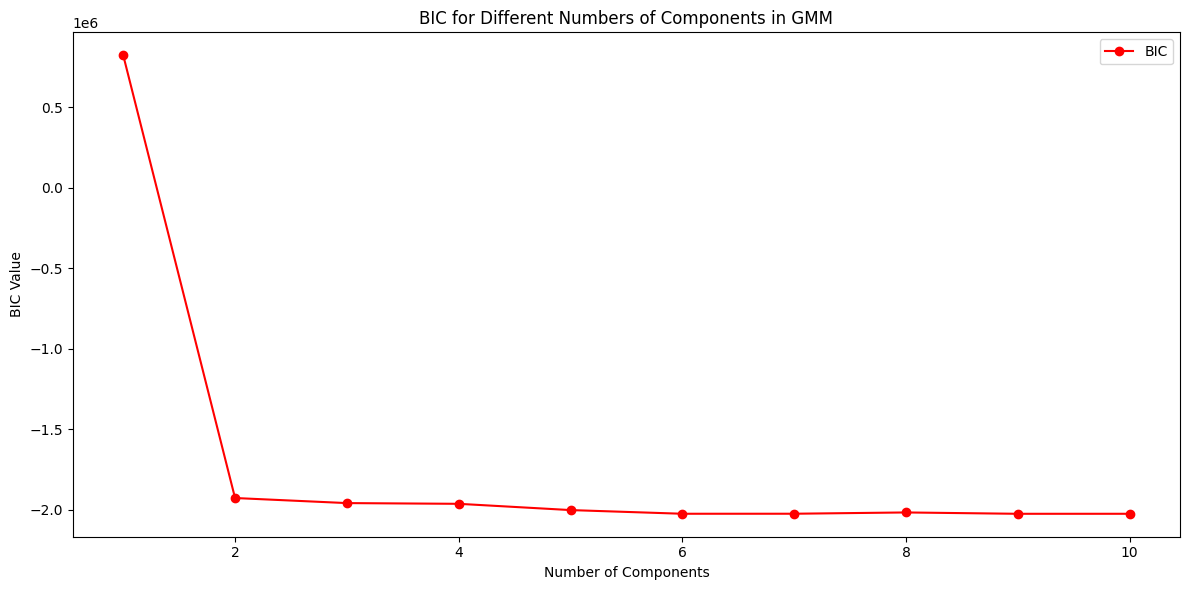

Best number of components (based on BIC): 9


In [28]:
from sklearn.mixture import GaussianMixture

# Define the range of components to try (e.g., 1 to 10 components)
n_components_range = range(1, 11)

# Initialize list to store BIC values
bic_values = []

# Fit Gaussian Mixture Models for each number of components and compute BIC
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_train)  # Fit the GMM model to the training features (X_train)
    bic_values.append(gmm.bic(X_train))  # Store BIC value

# Plot BIC to visualize the optimal number of components
plt.figure(figsize=(12, 6))

plt.plot(n_components_range, bic_values, label='BIC', color='red', marker='o')

# Add labels and title
plt.xlabel('Number of Components')
plt.ylabel('BIC Value')
plt.title('BIC for Different Numbers of Components in GMM')

# Show the legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

# Print the number of components that minimize BIC
best_n_components_bic = n_components_range[np.argmin(bic_values)]

print(f"Best number of components (based on BIC): {best_n_components_bic}")


Even if it proposes 9 components, the large drop is at 2 components. I choose to first try with 2 components.

**1.4.2 Evaluation of components range**

Range chosen: 2-6 components

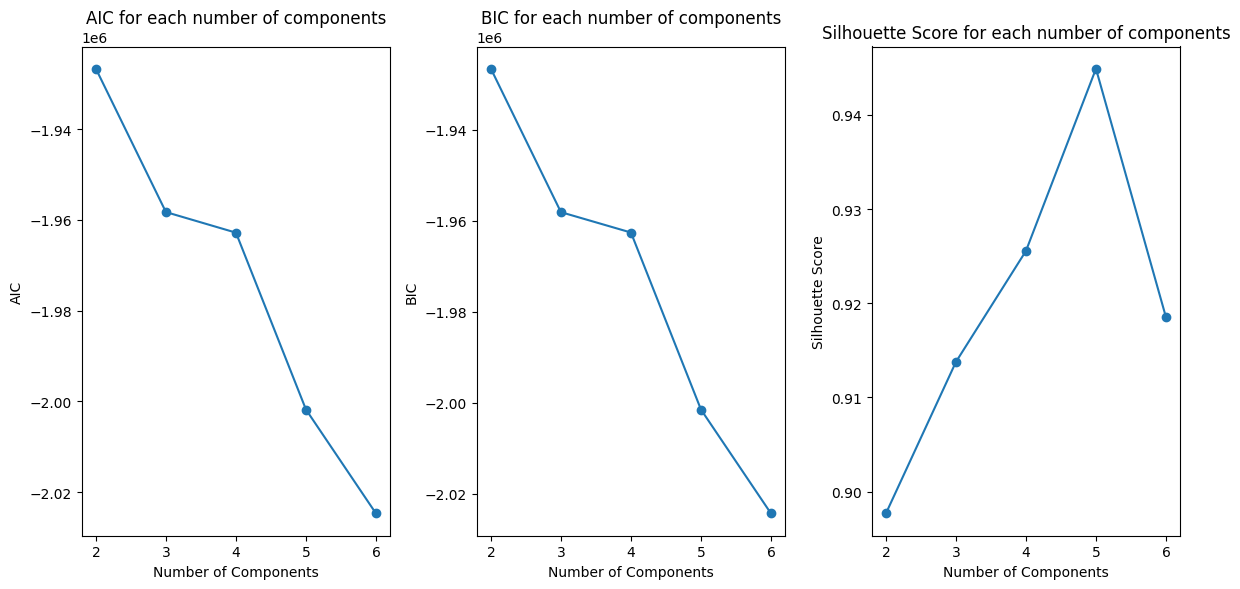

Best number of components: 6 based on BIC


In [31]:
# Range of components to evaluate
component_range = range(2, 7)  # For component numbers 2, 3, 4, 5, 6

# Store results
models = {}
aic_scores = []
bic_scores = []
silhouette_scores = []

# Loop through the range of components
for n_components in component_range:
    # Create and fit the Gaussian Mixture Model
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_train)  # Assuming X_train is your data

    # Store the model and metrics
    models[n_components] = gmm
    aic_scores.append(gmm.aic(X_train))
    bic_scores.append(gmm.bic(X_train))

    # Predict cluster labels
    labels = gmm.predict(X_train)

    # Calculate silhouette score
    silhouette = silhouette_score(X_train, labels)
    silhouette_scores.append(silhouette)

# Plot AIC, BIC, and Silhouette Score for each number of components
plt.figure(figsize=(12, 6))

# Plot AIC
plt.subplot(1, 3, 1)
plt.plot(component_range, aic_scores, marker='o')
plt.title('AIC for each number of components')
plt.xlabel('Number of Components')
plt.ylabel('AIC')

# Plot BIC
plt.subplot(1, 3, 2)
plt.plot(component_range, bic_scores, marker='o')
plt.title('BIC for each number of components')
plt.xlabel('Number of Components')
plt.ylabel('BIC')

# Plot Silhouette Score
plt.subplot(1, 3, 3)
plt.plot(component_range, silhouette_scores, marker='o')
plt.title('Silhouette Score for each number of components')
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# Select the best model based on the criteria you prefer (AIC, BIC, or silhouette score)
best_n_components = component_range[np.argmin(bic_scores)]
best_gmm_model = models[best_n_components]
print(f"Best number of components: {best_n_components} based on BIC")


**1.4.3 Co-variance evaluation**

Trying 4 co-variance option: full, tied, diagonal, spherical

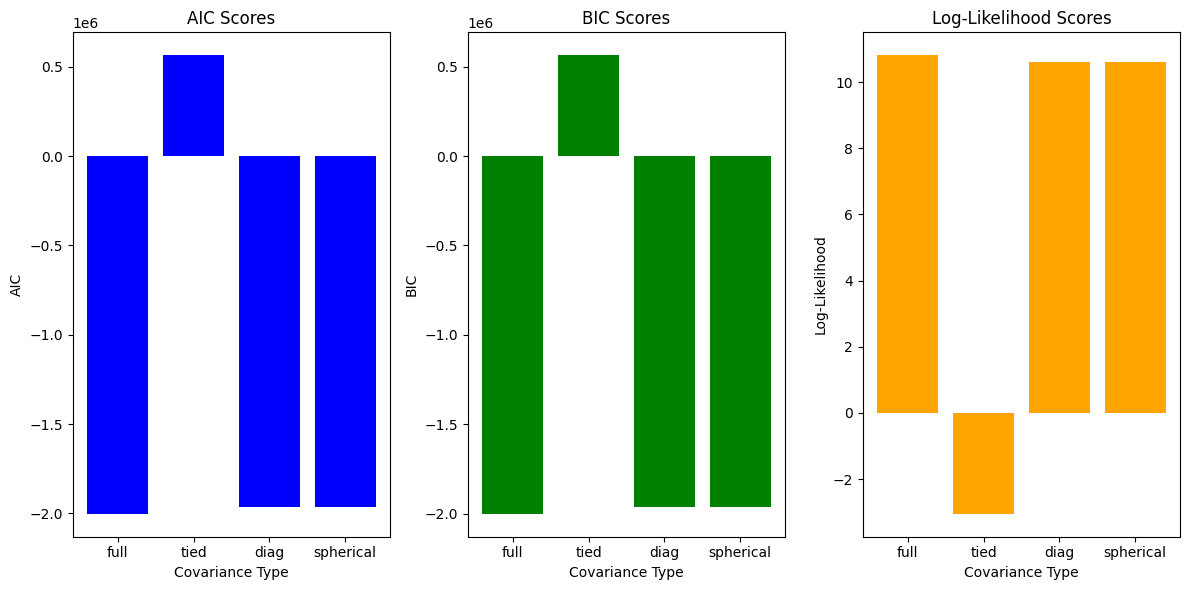

Best covariance type based on BIC: full


In [32]:
# Covariance types to evaluate
covariance_types = ['full', 'tied', 'diag', 'spherical']

# Number of components based on previous range component evaluation
n_components = 5

# Store results
models = {}
aic_scores = []
bic_scores = []
log_likelihoods = []

# Train a GMM for each covariance type
for cov_type in covariance_types:
    # Create and fit the GMM
    gmm = GaussianMixture(n_components=n_components, covariance_type=cov_type, random_state=42)
    gmm.fit(X_train)  # Assuming X_train is your dataset

    # Store the model and metrics
    models[cov_type] = gmm
    aic_scores.append(gmm.aic(X_train))
    bic_scores.append(gmm.bic(X_train))
    log_likelihoods.append(gmm.score(X_train))  # Log-likelihood score

# Plot AIC, BIC, and Log-Likelihood for each covariance type
plt.figure(figsize=(12, 6))

# AIC
plt.subplot(1, 3, 1)
plt.bar(covariance_types, aic_scores, color='blue')
plt.title('AIC Scores')
plt.ylabel('AIC')
plt.xlabel('Covariance Type')

# BIC
plt.subplot(1, 3, 2)
plt.bar(covariance_types, bic_scores, color='green')
plt.title('BIC Scores')
plt.ylabel('BIC')
plt.xlabel('Covariance Type')

# Log-Likelihood
plt.subplot(1, 3, 3)
plt.bar(covariance_types, log_likelihoods, color='orange')
plt.title('Log-Likelihood Scores')
plt.ylabel('Log-Likelihood')
plt.xlabel('Covariance Type')

plt.tight_layout()
plt.show()

# Determine the best covariance type based on the metric you choose
best_covariance_type = covariance_types[np.argmin(bic_scores)]
print(f"Best covariance type based on BIC: {best_covariance_type}")


# 1.5 Initialization of Gaussian Mixture Model

In [33]:
# Initialize the Gaussian Mixture Model with 2 components
gmm = GaussianMixture(n_components=5, covariance_type='full', random_state=42)


In [34]:
# Fit the GMM model to the training data (X_train)
gmm.fit(X_train)

GaussianMixture(n_components=5, random_state=42)

In [35]:
# Print the GMM parameters
print("Means of the components:\n", gmm.means_)
print("\nCovariances of the components:\n", gmm.covariances_)
print("\nWeights of the components:\n", gmm.weights_)

# Predict the component labels for each data point
labels = gmm.predict(X_train)

# Display the predicted labels
print("Predicted component labels for the data points:\n", labels)

Means of the components:
 [[ 0.          0.        ]
 [ 4.99604825  7.7429163 ]
 [ 0.          1.1852743 ]
 [40.5478191  38.61357738]
 [ 0.37369907  4.61645357]]

Covariances of the components:
 [[[ 1.00000000e-06  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e-06]]

 [[ 2.15596949e+01 -1.58341776e+00]
  [-1.58341776e+00  4.94068372e+01]]

 [[ 1.00000000e-06  0.00000000e+00]
  [ 0.00000000e+00  1.78542462e-01]]

 [[ 2.42537865e+03  1.33078741e+03]
  [ 1.33078741e+03  1.16461311e+03]]

 [[ 2.68242228e-01 -1.37916710e+00]
  [-1.37916710e+00  1.55271812e+01]]]

Weights of the components:
 [0.93050989 0.01253575 0.03085222 0.00190507 0.02419708]
Predicted component labels for the data points:
 [0 0 0 ... 0 0 0]


# 1.6 Visualization

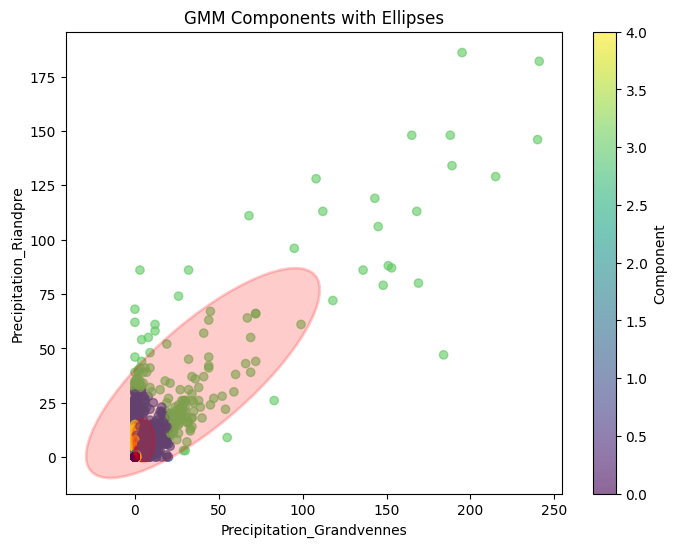

In [37]:
# Function to plot the Gaussian components as ellipses
def plot_gmm_ellipses(gmm, ax, n_components=5):
    for i in range(n_components):
        # Get the mean and covariance of the component
        mean = gmm.means_[i]
        covar = gmm.covariances_[i]

        # Create an ellipse representing the Gaussian component
        v, w = np.linalg.eigh(covar)  # Eigenvalues and eigenvectors
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)  # Scale the eigenvalues
        u = w[0] / np.linalg.norm(w[0])  # Get the first eigenvector (direction)

        # Plot the ellipse
        angle = np.arctan(u[1] / u[0])  # Angle of the ellipse
        angle = 180.0 * angle / np.pi  # Convert angle to degrees
        ell = plt.matplotlib.patches.Ellipse(mean, v[0], v[1], angle=angle,
                                              color='red', alpha=0.2, linewidth=2)
        ax.add_patch(ell)

# Plot the data points and GMM ellipses
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(X_train['Precipitation_Grandvennes'], X_train['Precipitation_Riandpre'], c=labels, cmap='viridis', marker='o', alpha=0.6)

# Plot the Gaussian ellipses
plot_gmm_ellipses(gmm, ax)

# Title and labels
plt.title('GMM Components with Ellipses')
plt.xlabel('Precipitation_Grandvennes')
plt.ylabel('Precipitation_Riandpre')
plt.colorbar(scatter, label='Component')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(


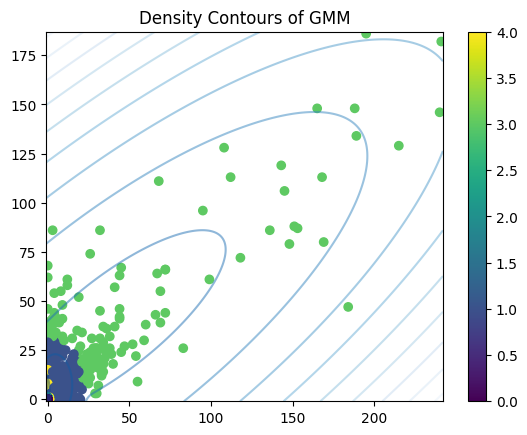

In [38]:
#Density contours of GMM

x_min, x_max = X_train['Precipitation_Grandvennes'].min() - 1, X_train['Precipitation_Grandvennes'].max() + 1
y_min, y_max = X_train['Precipitation_Riandpre'].min() - 1, X_train['Precipitation_Riandpre'].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))

grid_points = np.vstack([xx.ravel(), yy.ravel()]).T
Z = gmm.score_samples(grid_points)
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, levels=10, cmap='Blues', alpha=0.5)
plt.scatter(X_train['Precipitation_Grandvennes'], X_train['Precipitation_Riandpre'], c=labels, cmap='viridis')
plt.colorbar()
plt.title('Density Contours of GMM')
plt.show()


<ipython-input-39-533ae83a586e>:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(X_train[labels == i]['Precipitation_Grandvennes'], label=f'Component {i+1}')
<ipython-input-39-533ae83a586e>:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(X_train[labels == i]['Precipitation_Grandvennes'], label=f'Component {i+1}')


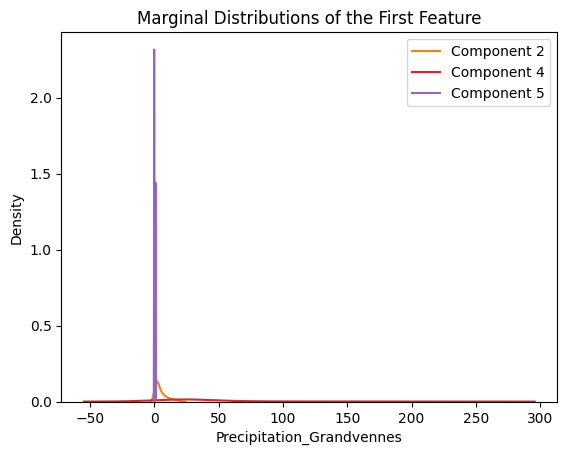

In [39]:
import seaborn as sns
for i in range(gmm.n_components):
    sns.kdeplot(X_train[labels == i]['Precipitation_Grandvennes'], label=f'Component {i+1}')
plt.title('Marginal Distributions of the First Feature')
plt.legend()
plt.show()


# 1.7 Evaluation of the model

In [40]:
# Evaluate the log-likelihood of the trained GMM
log_likelihood = gmm.score(X_train)
print(f'Log-Likelihood: {log_likelihood}')


Log-Likelihood: 10.813579198877079


In [41]:
# Get the labels predicted by the GMM
labels = gmm.predict(X_train)

# Compute silhouette score
silhouette = silhouette_score(X_train, labels)
print(f'Silhouette Score: {silhouette}')


Silhouette Score: 0.9448984411566096


# 2. Complex GMM with 5 stations

Complete the same process than with 2 station but with 5 stations
